# Exploratory Data Analysis

* How many faces ? Per gender ? Per age ?
* How does these faces look like ?
* Resolution ?
* Is there any data to remove ?

In [1]:
import numpy as np
import os.path as op
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
import pickle
from collections import Counter

plt.style.use('ggplot')

* **How many images do we have (training/validation) ?**

In [2]:
DATADIR = '/datascience/datasets/faces/'
TRAINING_SET = op.join(DATADIR, 'UTKFace_train')
VALIDATION_SET = op.join(DATADIR, 'UTKFAce_val')

training_filenames = glob(op.join(TRAINING_SET, '*'))
validation_filenames = glob(op.join(VALIDATION_SET, '*'))
print('Training set :', training_filenames.__len__())
print('Validation set :', validation_filenames.__len__())

Training set : 23708
Validation set : 9780


* **How does these faces look like ?**

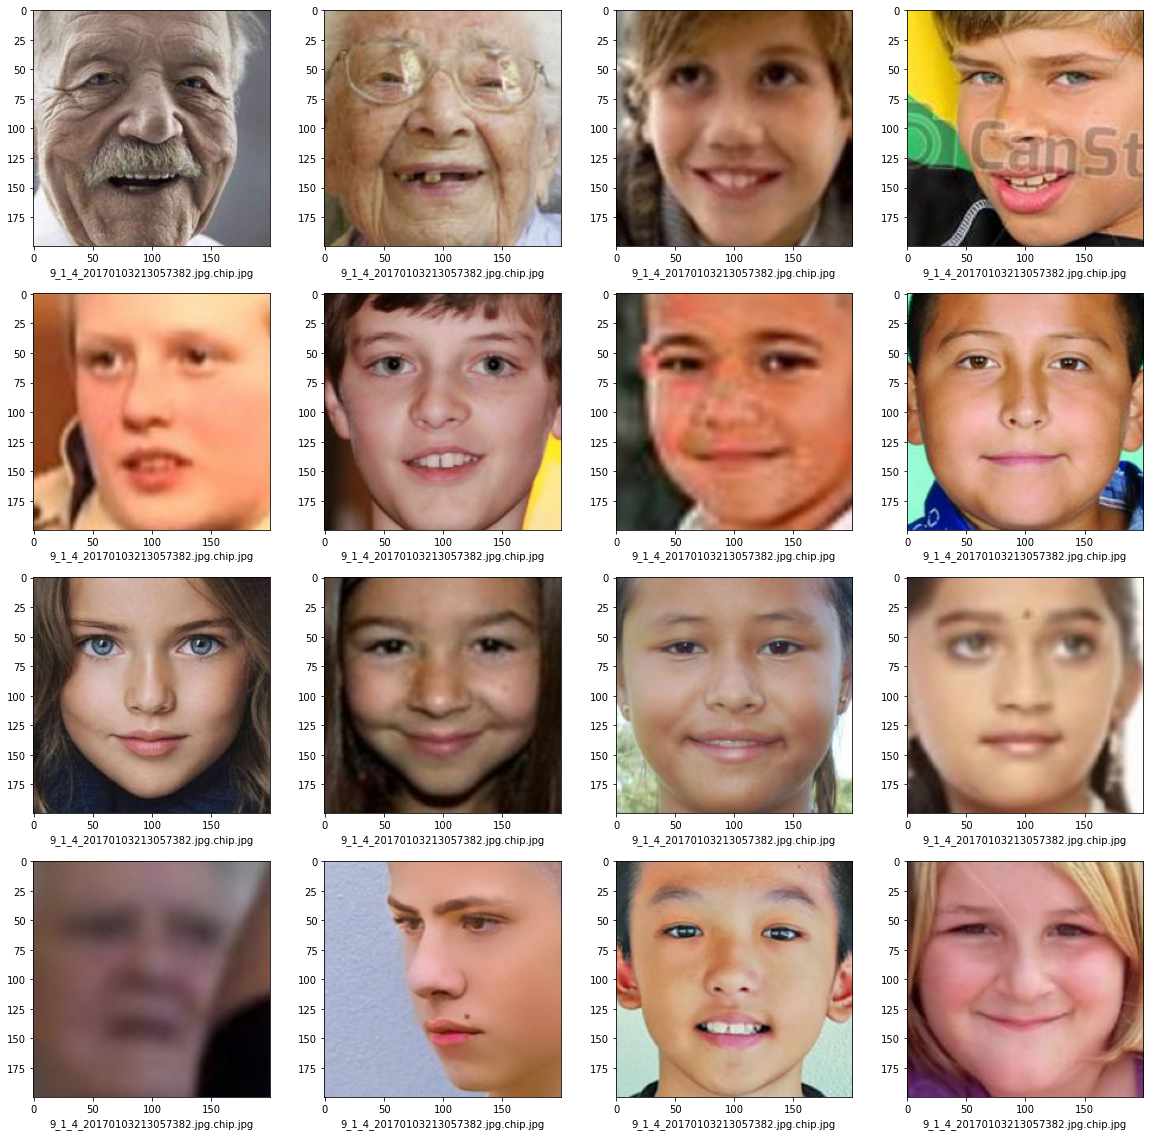

In [21]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = np.ravel(axs)

for i in range(4*4):
    fn = training_filenames[i * 15]
    img = plt.imread(fn)
    imgplot = axs[i].imshow(img)
    axs[i].set_xlabel(name)
plt.show()

* **What is the resolution of these images ?**

In [23]:
def get_shape_image(fn):
    img = plt.imread(fn)
    return img.shape
    
print(f'Shape of an image : {get_shape_image(training_filenames[0])}')

# Check resolution for each file
for name in training_filenames:
    shape = get_shape_image(name)
    assert shape[0] == shape[1] == 200
    

for name in validation_filenames:
    shape = get_shape_image(name)
    assert shape[0] == shape[1] == 200
    
print('Assertion true')

Shape of an image : (200, 200, 3)
Assertion true


* **Is there any data to remove ?**

The test consists in using FaceNet to detect if the image contains a face or not.

In [5]:
from facetection.utils.face_detection import detect_face_box
import cv2

fake_faces = []
for src in tqdm(training_filenames):
    img = cv2.imread(src)
    confidence, _, _, _, _ = detect_face_box(img)
    if confidence < 0.8:
        fake_faces.append(src)
    
print(f"Number of fake faces : {len(fake_faces)}")

Number of fake faces : 37


Let's have a look at some fake faces.

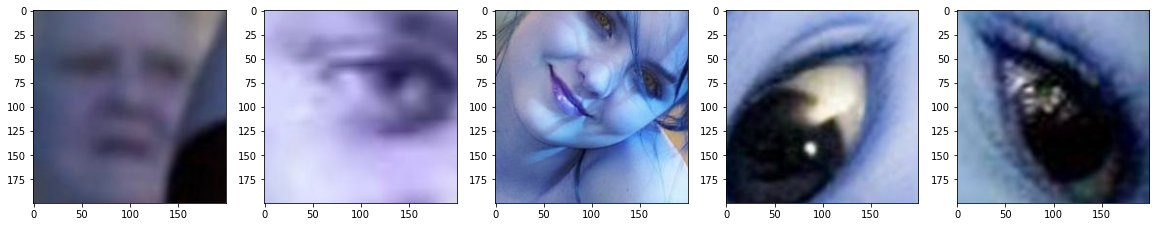

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs = np.ravel(axs)

for i in range(5):
    ax = axs[i]
    img = cv2.imread(fake_faces[i])
    ax.imshow(img)

We remove them.

In [5]:
for face in fake_faces:
    os.remove(face)

We do the same with the **validation set**.

In [16]:
val_fake_faces = []
for src in tqdm(validation_filenames):
    img = cv2.imread(src)
    confidence, _, _, _, _ = detect_face_box(img)
    if confidence < 0.8:
        val_fake_faces.append(src)
    
print(f"Number of fake faces : {len(val_fake_faces)}")

Number of fake faces : 10


In [6]:
for face in val_fake_faces:
    os.remove(face)

We remove these fake faces before going any further.

In [4]:
with open('./serialized/fake_faces_training.pkl', 'rb') as f:
    fake_faces = pickle.load(f)
    
with open('./serialized/fake_faces_validation.pkl', 'rb') as f:
    val_fake_faces = pickle.load(f)
    
print(f'Shapes before : {len(training_filenames)} -- {len(validation_filenames)}')
training_filenames = list(set(training_filenames) - set(fake_faces))
validation_filenames = list(set(validation_filenames) - set(val_fake_faces))
print(f'Shapes after : {len(training_filenames)} -- {len(validation_filenames)}')

Shapes before : 23708 -- 9780
Shapes after : 23671 -- 9770


## Labels repartition

* **How are the ages distributed in the dataset ?**

In [24]:
gender_counter = Counter()
age_counter = Counter()
race_counter = Counter()

for filename in training_filenames:
    metadata = filename.split(os.sep)[-1].split('_')
    if len(metadata) == 4:
        age_counter[int(metadata[0])] += 1
        gender_counter[int(metadata[1])] += 1
        race_counter[int(metadata[-2])] += 1

Text(0, 0.5, 'Count')

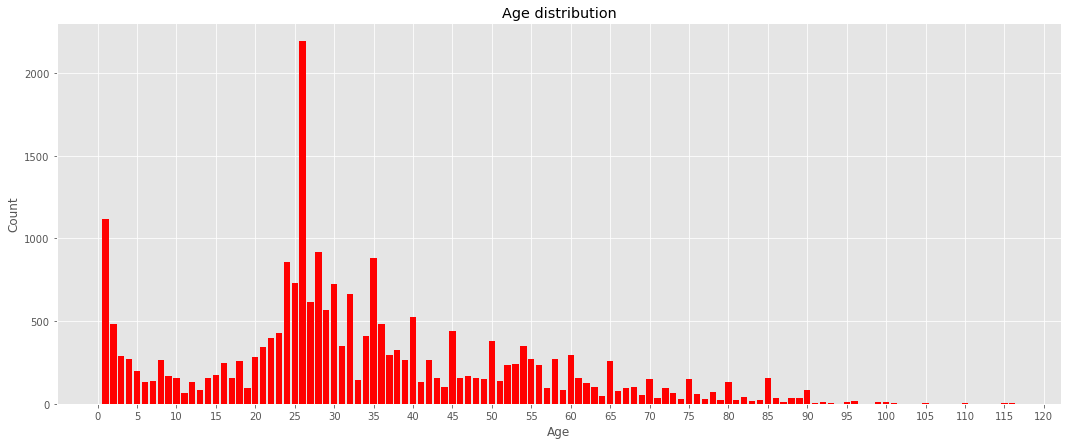

In [42]:
ages = np.array(sorted(age_counter.items()))

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.bar(ages[:,0], ages[:,1], color='red')
ax.set_title('Age distribution')
ax.set_xticks(range(0, 121, 5))
ax.set_xlabel('Age')
ax.set_ylabel('Count')

* The majority of them are 26 year-old (>2000 people).
* More than 1000 images represents babies with 1 year-old.

* **How is the gender distributed in the dataset ?**

Text(0.5, 1.0, 'Gender distribution')

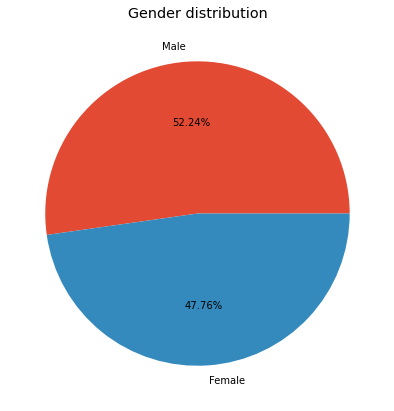

In [55]:
male_prop = gender_counter[0] / (gender_counter[0] + gender_counter[1])
fem_prop = gender_counter[1] / (gender_counter[0] + gender_counter[1])

x_genders = [male_prop, fem_prop]
labels = ['Male', 'Female']

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.pie(x_genders, labels=labels, autopct=lambda x: str(round(x, 2))+'%')
ax.set_title('Gender distribution')

* There is slightly more men than women in this dataset.

* **How are races distributed in this dataset ?**

In [60]:
decode_race = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other',
}

Text(0.5, 1.0, 'Race distribution')

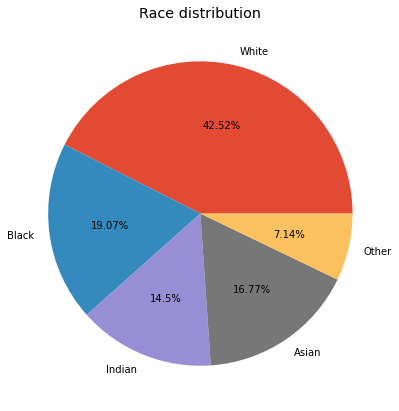

In [74]:
x_races = [race_counter[i] / sum(race_counter.values()) for i in range(len(race_counter))]
labels = [decode_race[r] for r in list(race_counter.keys())]

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.pie(x_races, labels=labels, autopct=lambda x: str(round(x, 2))+'%')
ax.set_title('Race distribution')

## Recognizing identity

### Gender recognizer